# Understanding Household Energy Consumption: A Deep Learning Approach

Welcome to a Deep Learning tutorial created by Hertie School's Masters of Data Science for Public Policy students. In it you will be able to apply sequence modeling techniques to analyze and predict household electric power consumption. We used the "Individual Household Electric Power Consumption" dataset from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/235/individual+household+electric+power+consumption), which includes diverse measures of electricity usage in a household over four years in Sceaux (7km of Paris, France) between December 2006 and November 2010 (47 months). This tutoral will focus on employing time series forecasting methods, like ARIMA, Recurrent Neural Networks (RNNs), and Long Short-Term Memory (LSTM) networks, to understand patterns in energy usage, forecast future consumption and comparing each other in terms of performance and results.

## **Understand the Data**
First, we need to understand the data we are going to be working with. Install the necessary libraries:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Adjust your working directory
import os
os.chdir('/content/drive/My Drive/Data_Projects/MDS/3rd semester/Deep learning LAB/Assignments/LSTM-time-series-tutorial')

In [3]:
# Based on https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

#Install Libraries in case you don't have them already in your local machine / environment
!pip install scalecast
!pip install pandas
!pip install matplotlib
!pip install numpy
!pip install scikeras
!pip install tensorflow
!pip zipfile


# Importing libraries
from scalecast.Forecaster import Forecaster
from scalecast.MVForecaster import MVForecaster
from scalecast.multiseries import export_model_summaries
from scalecast import GridGenerator
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import os
import requests
import zipfile
import io
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import SimpleRNN
from sklearn.model_selection import train_test_split


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 913.9/913.9 kB 11.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 82.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 40.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 48.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 84.0 MB/s eta 0:00:00
  Created wheel for scalecast: filename=SCALECAST-0.19.7-py3-none-any.whl size=125885 sha256=22b9698cc271ba55255b179e41363c791b3a10db4572b1449edf5aa29d3ea39d
  Stored in directory: /root/.cache/pip/wheels/96/45/e9/412ce9a9b95fd79732b3dc8954b81c8dc3c02b37e7bab910e1
Successfully built scalecast
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uni

## 1. Import the Data set
Let's go on the web and download the data we will be analyzing. In this step we will be accessing the "Household_Power_Consumption" in the UC Irvine Machine Learning Repository website, download the file, extract the .txt from the .zip and read it as a CSV.

In [4]:
# URL of the dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip'

# Download the file
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))

# Extract the file
z.extractall()

# Read the extracted txt file as a CSV
df_ori = pd.read_csv('household_power_consumption.txt', sep=';', header=0, low_memory=False, infer_datetime_format=True, parse_dates={'datetime':[0,1]}, index_col=['datetime'])


Let's see the top rows of the dataframe, what can we see from it?

In [5]:
# Display the first few rows of the dataframe
df_ori.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


### Variable Information
Some important information from this dataset:

1.date / 2. time: Date in format dd/mm/yyyy and time in format hh:mm:ss   
3.Global_active_power: household global minute-averaged active power (in kilowatt)  
4.Global_reactive_power: household global minute-averaged reactive power (in kilowatt)  
5.Voltage: minute-averaged voltage (in volt)  
6.Global_intensity: household global minute-averaged current intensity (in ampere)  
7.Sub_metering_1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).  
8.Sub_metering_2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.  
9.Sub_metering_3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.  

**This archive contains 2075259 measurements gathered in a house located in Sceaux (7km of Paris, France) between December 2006 and November 2010 (47 months).**

Notes:   
1.(global_active_power*1000/60 - sub_metering_1 - sub_metering_2 - sub_metering_3) represents the active energy consumed every minute (in watt hour) in the household by electrical equipment not measured in sub-meterings 1, 2 and 3.  
2.The dataset contains some missing values in the measurements (nearly 1,25% of the rows). All calendar timestamps are present in the dataset but for some timestamps, the measurement values are missing: a missing value is represented by the absence of value between two consecutive semi-colon attribute separators. For instance, the dataset shows missing values on April 28, 2007.

Let's change the column names to make it easier later on for our analysis. We will also create a copy of our dataframe to do our analysis

In [6]:
# Let's adjust columns names
df_ori.columns = ['total_real_power', 'reactive_power', 'voltage', 'current_intensity', 'kitchen', 'laundry_room', 'temp_control']
# Replicate the original dataframe
df = df_ori.copy()
df.head()

,total_real_power,reactive_power,voltage,current_intensity,kitchen,laundry_room,temp_control
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


Now that we have our new column names, let's check that there are no NA's in our dataset before doing any type

In [7]:
# Check NAs
df = df.replace('?', np.nan)
df.isnull().sum()

total_real_power     25979
reactive_power       25979
voltage              25979
current_intensity    25979
kitchen              25979
laundry_room         25979
temp_control         25979
dtype: int64

In case there are NA's, let's fill them up with the value registered from the previous day, since it would be the closest the the real value.

In [8]:
# Let's fill NAs with values from previous day

# Define a function to fill the missing values
def fill_missing(values):
    one_day = 60*24 # since there is one observation per minute, one day is 60 * 24
    for row in range(df.shape[0]):
        for col in range(df.shape[1]):
            if np.isnan(values[row][col]): # If it's a NA
                values[row,col] = values[row-one_day,col] # copy the value from the day before

df = df.astype('float32') # convert values to float

fill_missing(df.values) # call the function for each value in the dataset
df.isnull().sum() # Check if there are NA values

total_real_power     0
reactive_power       0
voltage              0
current_intensity    0
kitchen              0
laundry_room         0
temp_control         0
dtype: int64

Let's standardize the variables.

In [9]:
# Since the variables 'kitchen', 'laundry_room', 'temp_control' are in watts-hour and we have the measure for each minute, we can convert it to kwatts

df[['kitchen', 'laundry_room', 'temp_control']] = df[['kitchen', 'laundry_room', 'temp_control']] * 60 / 1000

Now let's create some dataset where we will have the data by hour and by day, so we can later do our forecasting. We will proceed with aggregarting the data for each column.

In [10]:
# Define aggregation functions for each column
agg_functions = {
    'total_real_power': 'sum',
    'reactive_power': 'sum',
    'voltage': 'mean',
    'current_intensity': 'sum',
    'kitchen': 'sum',
    'laundry_room': 'sum',
    'temp_control': 'sum'
}

# Resample the DataFrame by hour/day and aggregate using the defined functions
df_hourly = df.resample('H').agg(agg_functions)
df_daily = df.resample('D').agg(agg_functions)

Let's check if these new aggregated dataset are missing any value.

In [11]:
#Let's check if our dataset misses any day

# Get the min and max day from 'datetime' variable
min_date = df_daily.index.min()
max_date = df_daily.index.max()

# Generate a sequence of all dates between the minimum and maximum dates
all_dates = pd.date_range(start=min_date, end=max_date, freq='D')

# Compare
missing_dates = all_dates[~all_dates.isin(df_daily.index)]

# Print
if (missing_dates.size > 0):
  print("Missing dates:", missing_dates)

#Let's check if our dataset misses any hour

# Get the min and max date/time from 'datetime' variable
min_date = df_hourly.index.min()
max_date = df_hourly.index.max()

# Generate a sequence of all date/time between the minimum and maximum dates
all_dates = pd.date_range(start=min_date, end=max_date, freq='H')

# Compare
missing_dates = all_dates[~all_dates.isin(df_hourly.index)]

# Print
if (missing_dates.size > 0):
  print("Missing dates:", missing_dates)

Now that we are sure we have information for every day, let's visualize the consumption through our dataset.

First, lets see how hour daily consumption looks like.

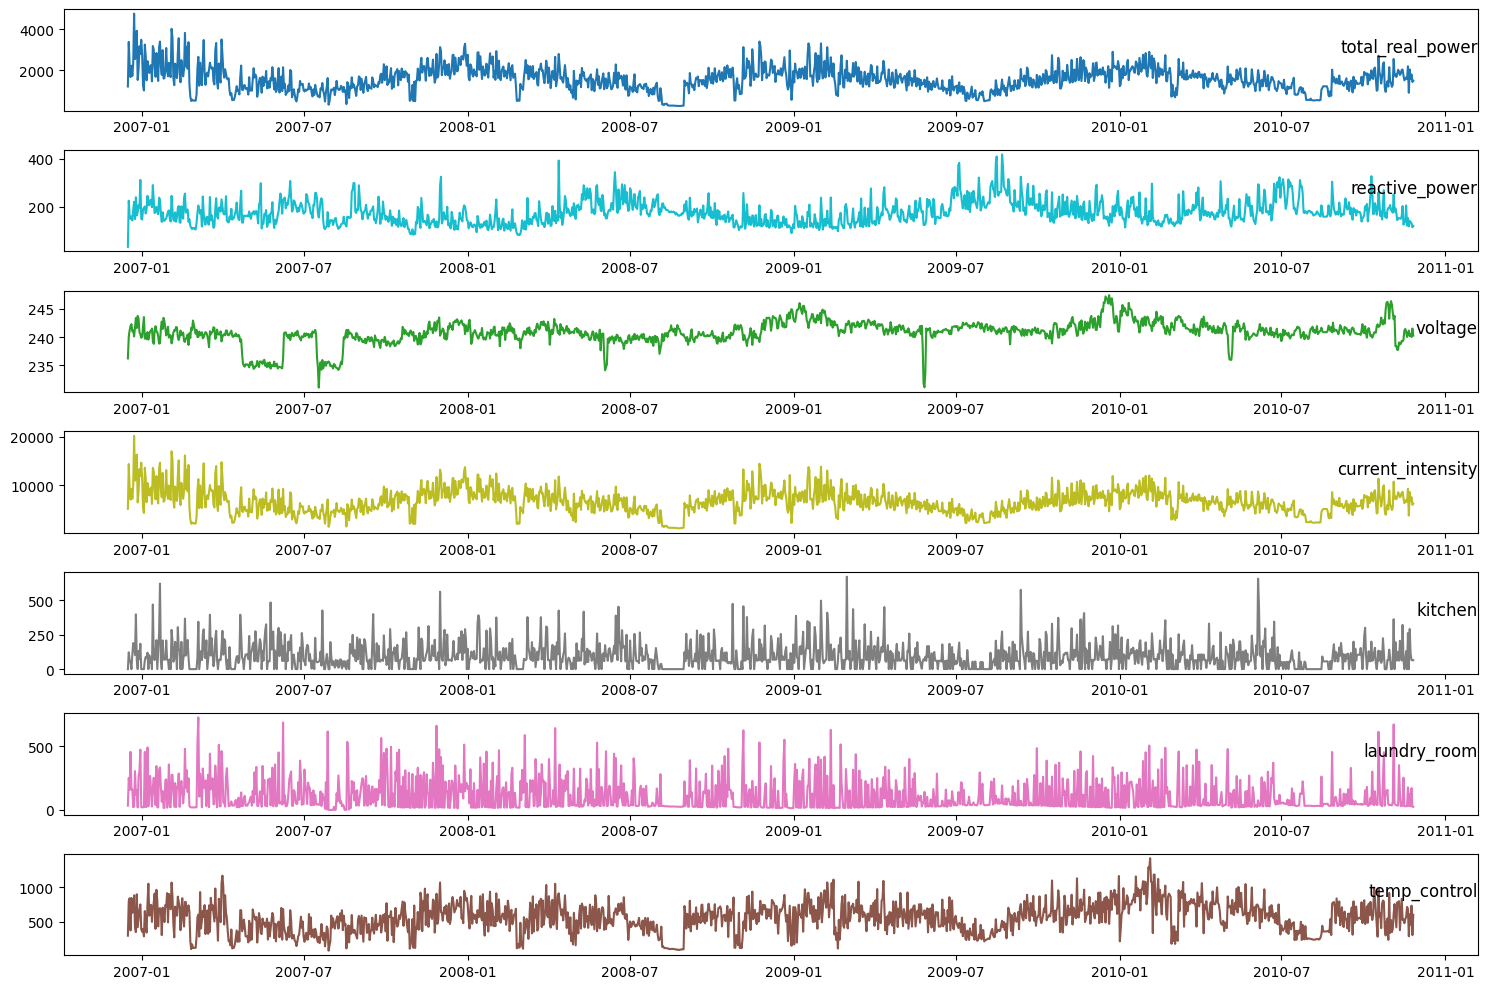

In [12]:
# Let's plot our daily consumption
values_daily = df_daily.values

# Specify columns to plot
groups = [0, 1, 2, 3, 4, 5, 6]
# Define colors for each plot
colors = ['#1f77b4', '#17becf', '#2ca02c', '#bcbd22', '#7f7f7f', '#e377c2', '#8c564b']

plt.figure(figsize=(15, 10))
for i, group in enumerate(groups):
    plt.subplot(len(groups), 1, i + 1)
    plt.plot(df_daily.index, values_daily[:, group], color=colors[i])
    plt.title(df_daily.columns[group], y=0.5, loc='right')
plt.tight_layout()
plt.show()


What about our hourly consumption?

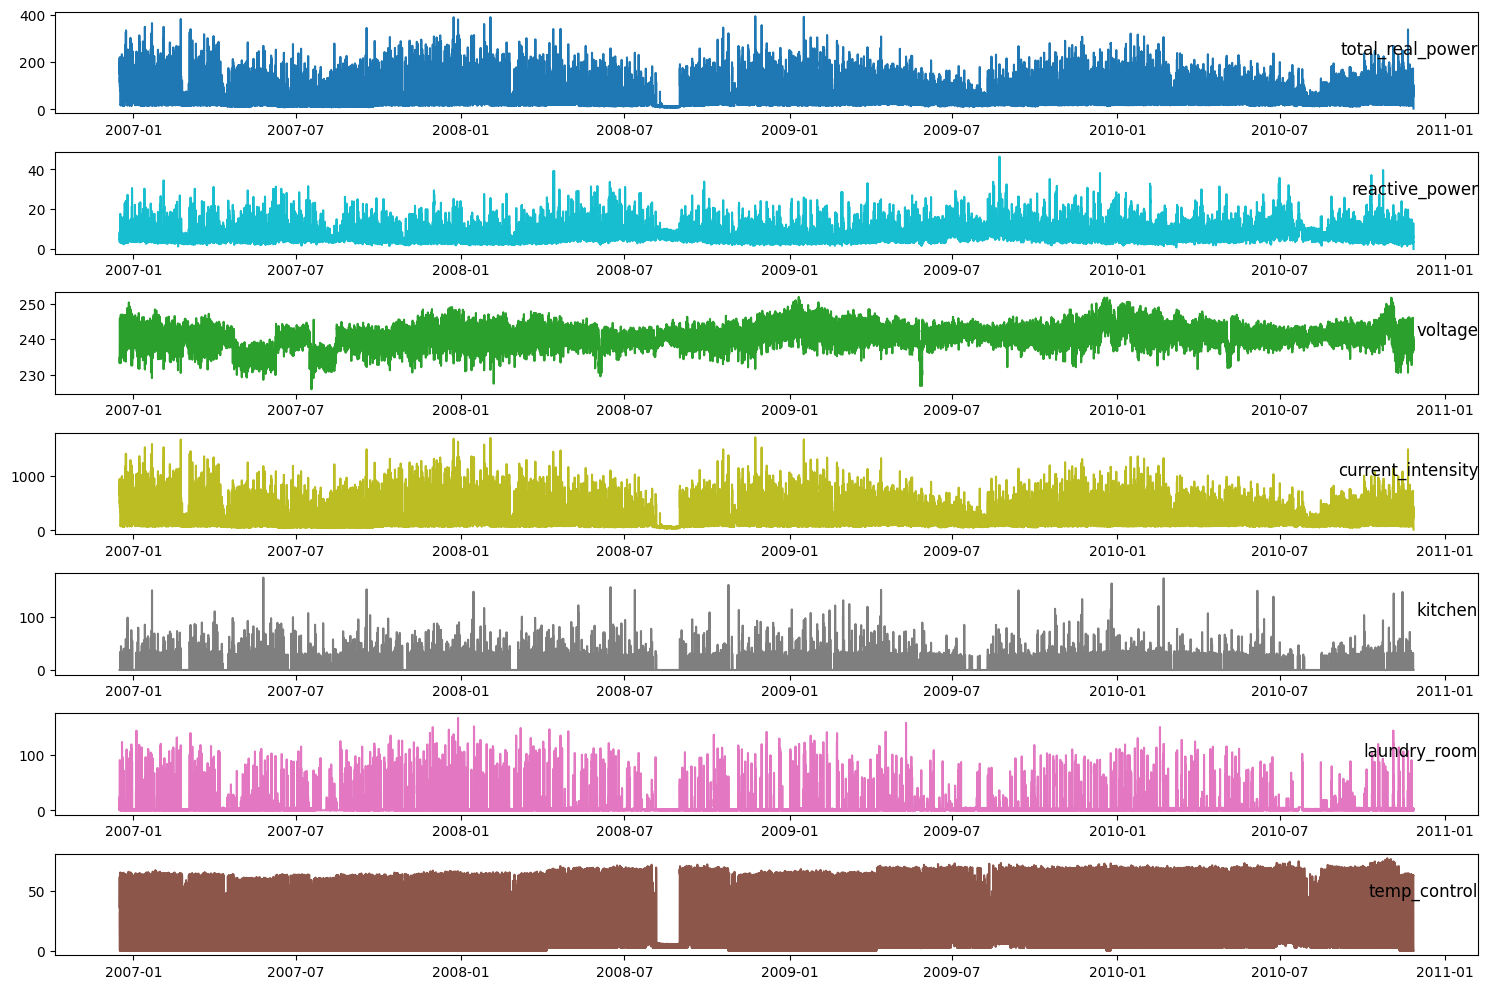

In [13]:
# Let's plot our hourly consumption
values_hourly = df_hourly.values

# Specify columns to plot
groups = [0, 1, 2, 3, 4, 5, 6]
# Define colors for each plot
colors = ['#1f77b4', '#17becf', '#2ca02c', '#bcbd22', '#7f7f7f', '#e377c2', '#8c564b']

plt.figure(figsize=(15, 10))
for i, group in enumerate(groups):
    plt.subplot(len(groups), 1, i + 1)
    plt.plot(df_hourly.index, values_hourly[:, group], color=colors[i])
    plt.title(df_hourly.columns[group], y=0.5, loc='right')
plt.tight_layout()
plt.show()

Now that we have done all of this, we need to convert our time series data set into a supervised learning dataset, ensure that all our values are *float*, and scale our data to a range betweeen 0 and 1, and constructs input-output sequences for model training, discarding unnecessary future timestep columns.

In [14]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()

    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names

    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)

    return agg


# ensure all data is float
values = values_daily.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 30, 1)

# drop last columns
#reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
reframed.drop(reframed.columns[-values_daily.shape[1]+1:], axis=1, inplace=True)

#Let's see the head of this new dataset.
print(reframed.head())

    var1(t-30)  var2(t-30)  var3(t-30)  var4(t-30)  var5(t-30)  var6(t-30)  \
30    0.211996    0.000000    0.315385    0.211006    0.000000    0.045090   
31    0.694252    0.499028    0.550493    0.695226    0.181875    0.345776   
32    0.431901    0.331329    0.620518    0.424618    0.095098    0.216451   
33    0.313037    0.302994    0.667476    0.311508    0.075058    0.627797   
34    0.436748    0.329256    0.686364    0.428075    0.000000    0.218680   

    var7(t-30)  var1(t-29)  var2(t-29)  var3(t-29)  ...  var6(t-2)  var7(t-2)  \
30    0.162013    0.694252    0.499028    0.550493  ...   0.245685   0.447695   
31    0.536762    0.431901    0.331329    0.620518  ...   0.348088   0.520463   
32    0.566912    0.313037    0.302994    0.667476  ...   0.184904   0.617903   
33    0.218615    0.436748    0.329256    0.686364  ...   0.053184   0.235805   
34    0.568916    0.325660    0.285998    0.608740  ...   0.473780   0.658027   

    var1(t-1)  var2(t-1)  var3(t-1)  var4(t-

We are ready for our forecast! Let's restart the index and save the modified files in our /data folder in order to access them in next steps.

In [15]:
# Reset the index
df_hourly.reset_index(inplace=True)
df_daily.reset_index(inplace=True)

# Export results
df_daily.to_csv('data/df_daily.csv', index=False)
df_hourly.to_csv('data/df_hourly.csv', index=False)
reframed.to_csv('data/reframed.csv', index=False)


## 2. ARIMA Forecast

The ARIMA **(AutoRegressive Integrated Moving Average)** forecasting process involves identifying the patterns in time series data to predict future points by considering the lags of difference-stationarized series and the lagged forecast errors. It is a classical statistical method that provides a robust approach for understanding and predicting future trends in data. Despite not being a deep learning tool, ARIMA is crucial for data scientists as it requires less computational power, offers interpretability, and often serves as a benchmark for evaluating the performance of more complex models.

Now we will set up a pipeline to forecast consumption data using the ARIMA process.

In [26]:
# import necessary packages
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from pmdarima import auto_arima

Let's plot all of the variables together, are they stationary? Do they exihibit any particular trend of seasonal patttern? We are going to perform the Dickey-Fuller test to check this. This is a statistical test used to determine whether a time series is stationary or has a unit root, which implies non-stationarity.

In [17]:
daily_data = df_daily.copy()

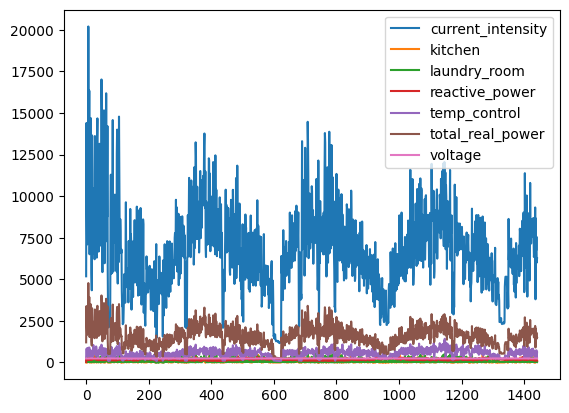

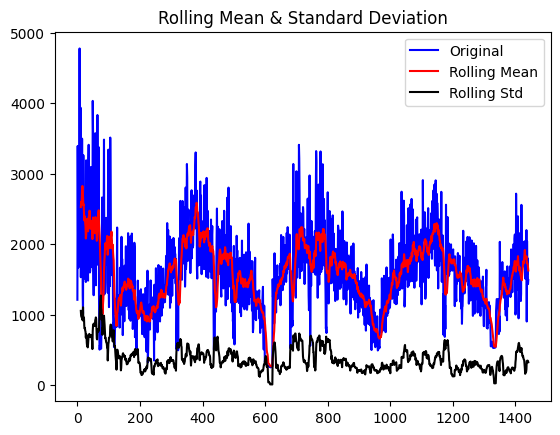

Results of Dickey-Fuller Test:
Test Statistic                   -3.697385
p-value                           0.004150
#Lags Used                       22.000000
Number of Observations Used    1419.000000
Critical Value (1%)              -3.434967
Critical Value (5%)              -2.863579
Critical Value (10%)             -2.567856
dtype: float64


In [18]:
# Select all columns except 'Index' for plotting
columns_to_plot = daily_data.columns.difference(['index'])
columns_to_plot = daily_data.columns.difference(['datetime'])

# Plot the selected columns
daily_data[columns_to_plot].plot()
plt.show()

# Function to test stationarity
def test_stationarity(timeseries):
    # Determining rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()

    # Plot rolling statistics
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolling_mean, color='red', label='Rolling Mean')
    plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    # Perform Dickey-Fuller test
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

#Let's test the total_real_power variable with the DIckey-Fuller test
test_stationarity(daily_data['total_real_power'])

Let's go over each key result from the DDickey-Fuller test.
1. **Test Statistic**: The test statistic of -3.697385 indicates the test's outcome is statistically significant enough to suggest the time series is stationary.
2. **p-value**: A p-value of 0.004150 means there is a very low probability that the time series has a unit root, supporting stationarity.
3. **#Lags Used**: 22 lags were used in the test, representing the number of past data points considered for calculating the test statistic.
4. **Number of Observations Used**: The test was conducted using 1419 data observations from the time series.
5. **Critical Values**: The critical values at 1%, 5%, and 10% are thresholds for the test statistic at which the null hypothesis can be rejected with corresponding levels of confidence.

With these results we can go ahead and perform our ARIMA forecast.

Let's firstly define our training and testing dataset

In [19]:
# Define the training and testing dataset
train_size = int(len(daily_data) * 0.8)  # 80% of data for training
train, test = daily_data[0:train_size], daily_data[train_size:]

Let's run an ARIMA model , what are the best parameters for it?

In [20]:
# Finding the best parameters for our ARIMA model
auto_model = auto_arima(train['total_real_power'],
                        seasonality=False,
                        suppress_warnings=True,
                        trace=True)

print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=17409.199, Time=2.16 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=18131.623, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=17609.379, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=17758.587, Time=0.49 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=20451.341, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=17408.984, Time=3.10 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=17708.993, Time=1.35 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=17445.016, Time=2.88 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=17396.941, Time=4.75 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=17642.731, Time=1.83 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=17440.132, Time=7.76 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=17400.707, Time=6.35 sec
 ARIMA(0,0,4)(0,0,0)[0] intercept   : AIC=17560.196, Time=2.44 sec
 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=17421.815, Time=2.03 sec
 ARIMA(1,0,3)(0,0,0

Fit the ARIMA model on the training data using the best found parameters above

In [21]:
model=ARIMA(train['total_real_power'],order=(1,0,3))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       total_real_power   No. Observations:                 1153
Model:                 ARIMA(1, 0, 3)   Log Likelihood               -8692.672
Date:                Thu, 14 Dec 2023   AIC                          17397.344
Time:                        11:58:07   BIC                          17427.645
Sample:                             0   HQIC                         17408.780
                               - 1153                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1599.2625    140.237     11.404      0.000    1324.404    1874.121
ar.L1          0.9774      0.008    118.901      0.000       0.961       0.993
ma.L1         -0.6171      0.023    -26.832      0.000      -0.662      -0.572
ma.L2         -0.2643      0.027     -9.718      0.000      -0.318      -0.211
ma.L3          0.1027      0.023      4.431      0.000       0.057       0.148
sigma2       2.02e+05   6322.230     31.954      0.000     1.9e+05    2.14e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               340.63
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.44   Skew:                             0.73
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Now, we can make predictions on the test set

In [22]:
start = len(train)
end = len(train) + len(test) - 1
pred = model_fit.predict(start=start, end=end, typ= 'levels')
print(pred)

min_value = daily_data['total_real_power'].min()
max_value = daily_data['total_real_power'].max()

print(f"Minimum value in 'total_real_power': {min_value}")
print(f"Maximum value in 'total_real_power': {max_value}")

1153    2128.431884
1154    2171.281821
1155    2137.410660
1156    2125.231793
1157    2113.328546
           ...     
1437    1600.108555
1438    1600.089407
1439    1600.070693
1440    1600.052403
1441    1600.034526
Name: predicted_mean, Length: 289, dtype: float64
Minimum value in 'total_real_power': 250.29800415039062
Maximum value in 'total_real_power': 4773.38623046875


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In order assest the model's prediction accuracy we will use the RMSE (Root Mean Squared Error), that quantifyies the average magnitude of the forecast errors in the same units as the data.

In [27]:
#RMSE calculation
rmse_Arima = sqrt(mean_squared_error(test['total_real_power'], pred))
mae_Arima = sqrt(mean_absolute_error(test['total_real_power'], pred))

print('Test ARIMA RMSE:', rmse_Arima)
print('Test ARIMA MAE:', mae_Arima)

Test ARIMA RMSE: 479.7994216077756
Test ARIMA MAE: 19.353990264141284


Let's visualize how this prediction went like.

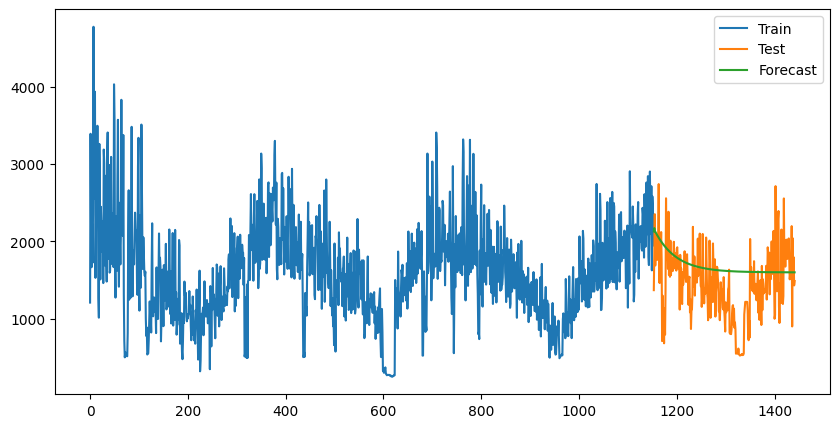

In [28]:
# Plot the actual vs predicted values
plt.figure(figsize=(10, 5))
plt.plot(train.index, train['total_real_power'], label='Train')
plt.plot(test.index, test['total_real_power'], label='Test')
plt.plot(test.index, pred, label='Forecast')
plt.legend()
plt.show()

As you can see, the ARIMA model is capturing some of the patterns in the data but with a moderate level of error. The RMSE value indicates that, on average, the model's predictions deviate from the actual observed values by approximately 479.79 units. Let's see if we can improve our prediction abilities using more advanced forecasting methods.

## RNN Forecast

Recurrent Neural Networks, or RNNs, are a type of neural network specially designed to recognize patterns in sequences of data, such as temperatures over time or stock prices. They're useful for forecasting because they can remember past information and use it to make predictions about what comes next. Compared to traditional methods like ARIMA, RNNs can handle more complex patterns and can be more accurate when the data has trends, cycles, or if multiple factors influence the forecast.

First, we are going to check the correlation between the differnt variables, since we would like to see if we can use them to predict the total_real_power as well.

In [29]:
#Let's check the correlation between the variables - correlation matrix
df_corr = df.corr()

print('\nCorrelation matrix:')
print(df_corr)


Correlation matrix:
                   total_real_power  reactive_power   voltage  \
total_real_power           1.000000        0.247088 -0.396853   
reactive_power             0.247088        1.000000 -0.110802   
voltage                   -0.396853       -0.110802  1.000000   
current_intensity          0.998884        0.266219 -0.408480   
kitchen                    0.484110        0.123006 -0.195018   
laundry_room               0.434012        0.139321 -0.165702   
temp_control               0.638966        0.089949 -0.265935   

                   current_intensity   kitchen  laundry_room  temp_control  
total_real_power            0.998884  0.484110      0.434012      0.638966  
reactive_power              0.266219  0.123006      0.139321      0.089949  
voltage                    -0.408480 -0.195018     -0.165702     -0.265935  
current_intensity           1.000000  0.489027      0.439780      0.626952  
kitchen                     0.489027  1.000000      0.054468      0.10199

In [30]:
from scalecast.Forecaster import Forecaster
from scalecast.MVForecaster import MVForecaster
from scalecast.multiseries import export_model_summaries
from scalecast import GridGenerator

Let's initialize the time series forecasters for the different household power consumption variables using the Scalecast package to prepare for an evaluation of their forecasting performance.

In [44]:
df = df_daily.copy()
df.set_index('datetime', inplace=True)

In [45]:
df.columns

Index(['total_real_power', 'reactive_power', 'voltage', 'current_intensity',
       'kitchen', 'laundry_room', 'temp_control'],
      dtype='object')

In [46]:
#Let's use Scalecast package to check some characteristics of our time series

def create_forecaster(y, current_dates, test_length, future_dates, validation_length=4, frequency='D'):
    return Forecaster(
        y=y,
        current_dates=current_dates,
        test_length=test_length,
        future_dates=future_dates,
        validation_length=validation_length,
        metrics=['rmse', 'r2'],
        cis=True,
    )

n_future_dates = 7
n_test_length = 0.2

f_tot_power = create_forecaster(df['total_real_power'], df.index, n_test_length, n_future_dates)
f_reac_power = create_forecaster(df['reactive_power'], df.index, n_test_length, n_future_dates)
f_voltage = create_forecaster(df['voltage'], df.index, n_test_length, n_future_dates)
f_current = create_forecaster(df['current_intensity'], df.index, n_test_length, n_future_dates)
f_kitchen = create_forecaster(df['kitchen'], df.index, n_test_length, n_future_dates)
f_laundry = create_forecaster(df['laundry_room'], df.index, n_test_length, n_future_dates)
f_temp_control = create_forecaster(df['temp_control'], df.index, n_test_length, n_future_dates)

Now, let's examine the autocorrelation in our time series data for each variable to identify any patterns or relationships at different time lags, using ACF (Autocorrelation Function) and PACF (Partial Autocorrelation Function) plots.

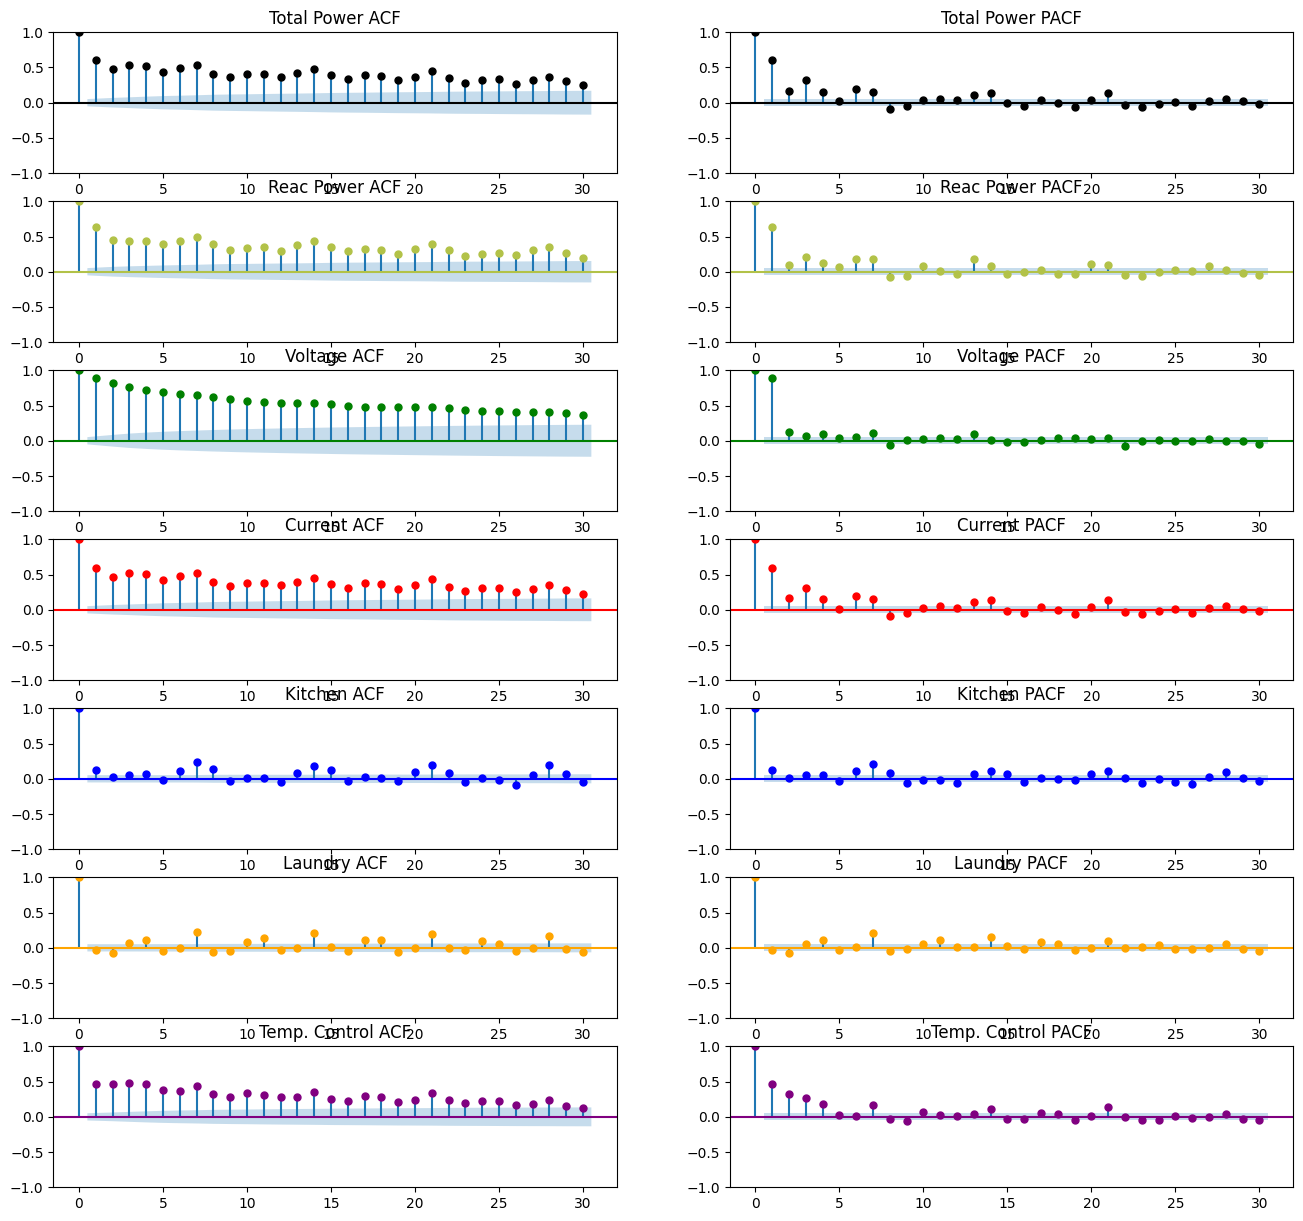

In [47]:
#Let´s check autocorrelation

n_lags = 30

figs, axs = plt.subplots(7, 2,figsize=(16,15))

f_tot_power.plot_acf(
    ax=axs[0,0],
    title='Total Power ACF',
    lags=n_lags,
    color='black'
)
f_tot_power.plot_pacf(
    ax=axs[0,1],
    title='Total Power PACF',
    lags=n_lags,
    color='black',
    method='ywm'
)
f_reac_power.plot_acf(
    ax=axs[1,0],
    title='Reac Power ACF',
    lags=n_lags,
    color='#B2C248'
)
f_reac_power.plot_pacf(
    ax=axs[1,1],
    title='Reac Power PACF',
    lags=n_lags,
    color='#B2C248',
    method='ywm'
)
f_voltage.plot_acf(
    ax=axs[2,0],
    title='Voltage ACF',
    lags=n_lags,
    color='green'
)
f_voltage.plot_pacf(
    ax=axs[2,1],
    title='Voltage PACF',
    lags=n_lags,
    color='green',
    method='ywm'
)
f_current.plot_acf(
    ax=axs[3,0],
    title='Current ACF',
    lags=n_lags,
    color='red'
)
f_current.plot_pacf(
    ax=axs[3,1],
    title='Current PACF',
    lags=n_lags,
    color='red',
    method='ywm'
)
f_kitchen.plot_acf(
    ax=axs[4,0],
    title='Kitchen ACF',
    lags=n_lags,
    color='blue'
)
f_kitchen.plot_pacf(
    ax=axs[4,1],
    title='Kitchen PACF',
    lags=n_lags,
    color='blue',
    method='ywm'
)
f_laundry.plot_acf(
    ax=axs[5,0],
    title='Laundry ACF',
    lags=n_lags,
    color='orange'
)
f_laundry.plot_pacf(
    ax=axs[5,1],
    title='Laundry PACF',
    lags=n_lags,
    color='orange',
    method='ywm'
)
f_temp_control.plot_acf(
    ax=axs[6,0],
    title='Temp. Control ACF',
    lags=n_lags,
    color='purple'
)
f_temp_control.plot_pacf(
    ax=axs[6,1],
    title='Temp. Control PACF',
    lags=n_lags,
    color='purple',
    method='ywm'
)
plt.show()


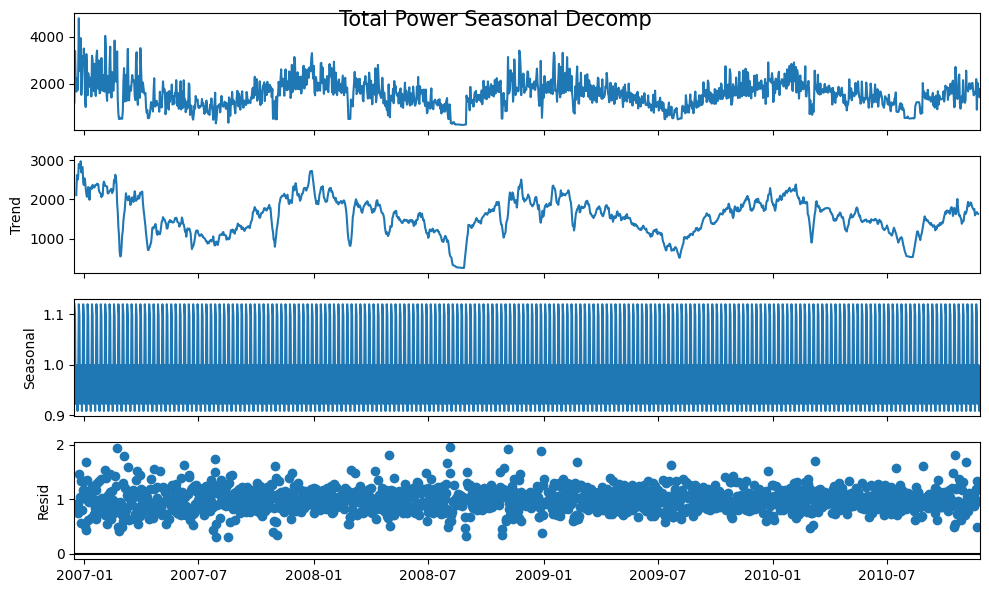

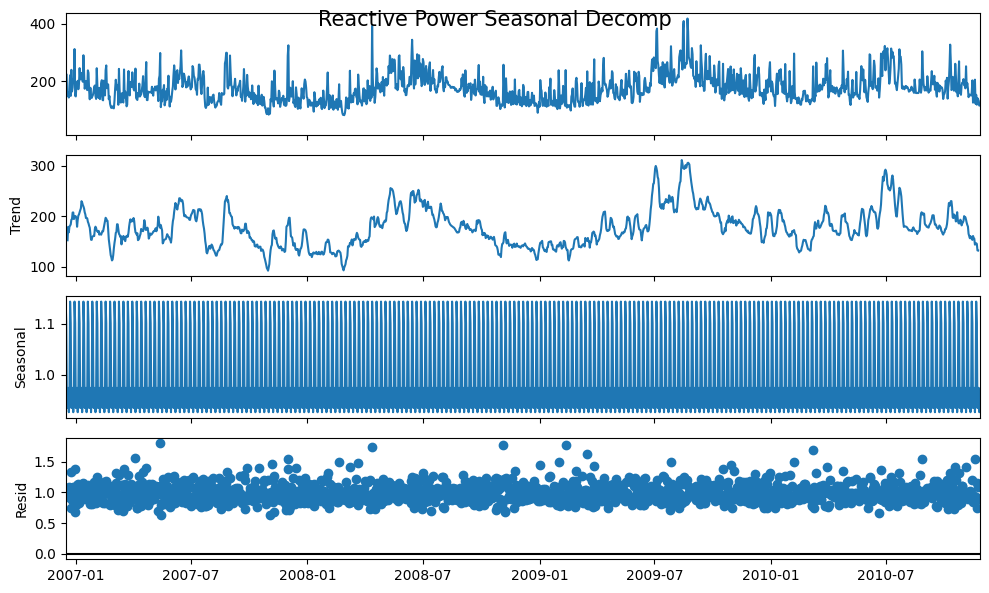

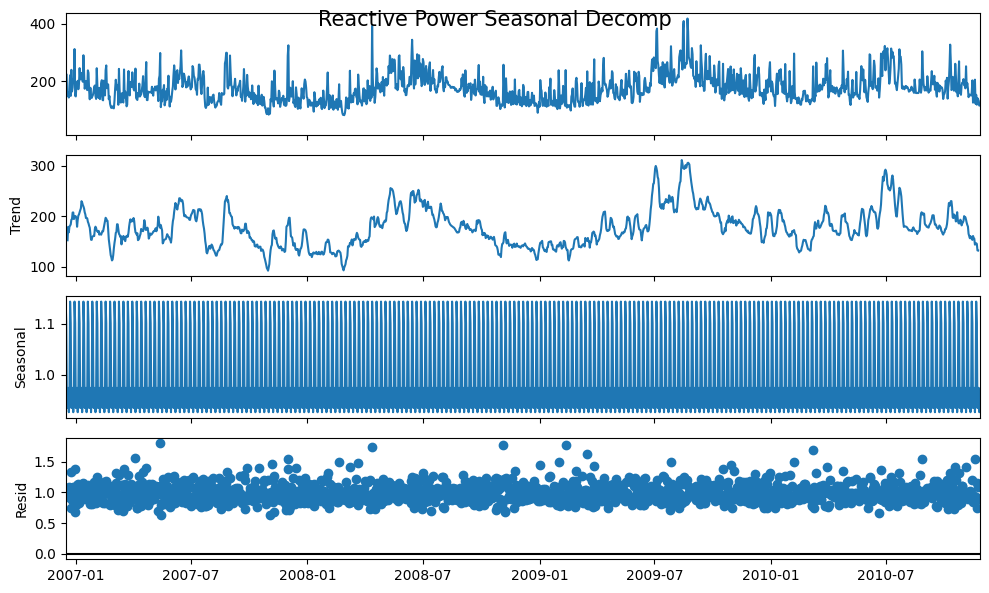

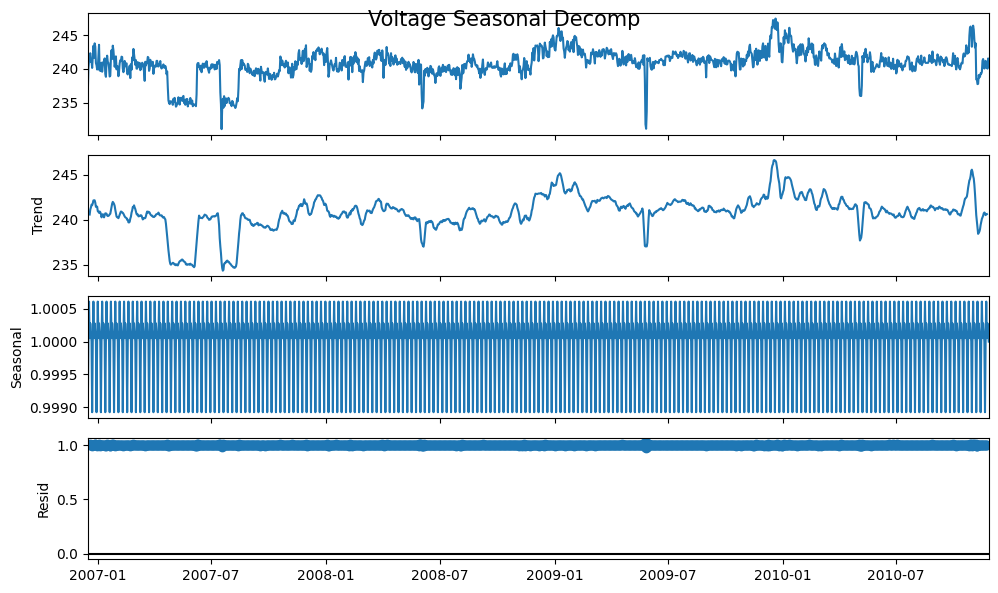

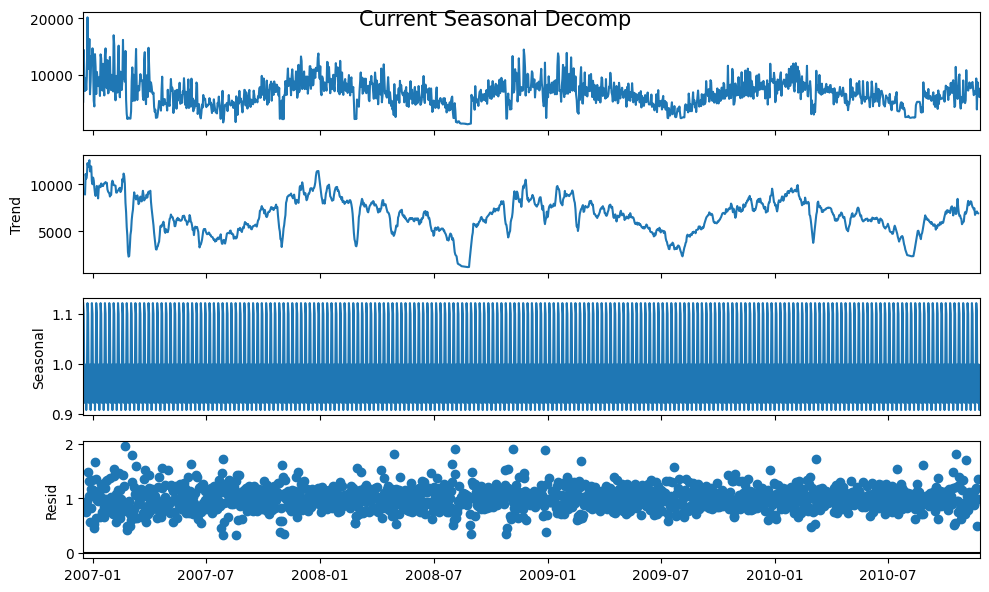

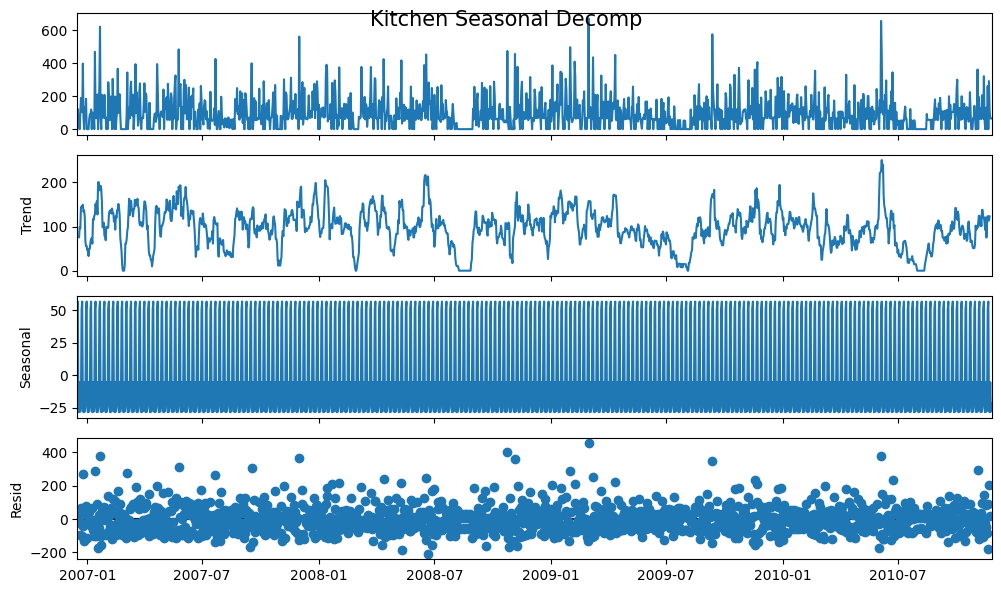

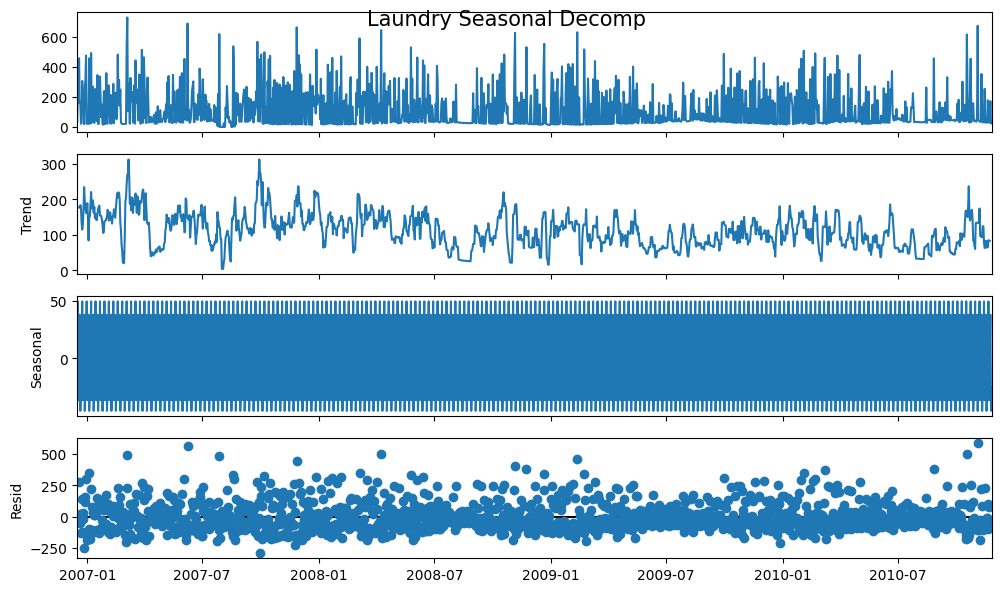

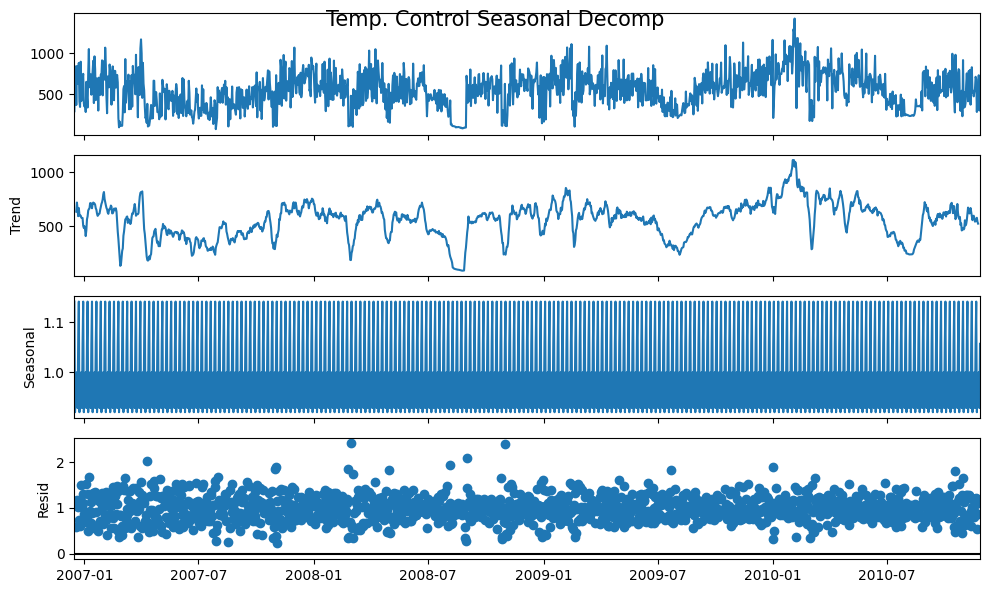

In [48]:
# Now let's decompose the series to check Time Series Components

plt.rc("figure",figsize=(10,6))
f_tot_power.seasonal_decompose(model='mul').plot()
plt.suptitle('Total Power Seasonal Decomp',size=15)

f_reac_power.seasonal_decompose(model='mul').plot()
plt.suptitle('Reactive Power Seasonal Decomp',size=15)

f_reac_power.seasonal_decompose(model='mul').plot()
plt.suptitle('Reactive Power Seasonal Decomp',size=15)

f_voltage.seasonal_decompose(model='mul').plot()
plt.suptitle('Voltage Seasonal Decomp',size=15)

f_current.seasonal_decompose(model='mul').plot()
plt.suptitle('Current Seasonal Decomp',size=15)

f_kitchen.seasonal_decompose(model='additive').plot()
plt.suptitle('Kitchen Seasonal Decomp',size=15)

f_laundry.seasonal_decompose(model='additive').plot()
plt.suptitle('Laundry Seasonal Decomp',size=15)

f_temp_control.seasonal_decompose(model='mul').plot()
plt.suptitle('Temp. Control Seasonal Decomp',size=15)

plt.show()

In [49]:
# Now let's check if each time serie is stationary or not

critical_pval = 0.05

# List of Forecaster objects
forecasters = [f_tot_power, f_reac_power, f_voltage, f_current, f_kitchen, f_laundry, f_temp_control]

# List of variable names
variables = ['Total Power', 'Reactive Power', 'Voltage', 'Current', 'Kitchen', 'Laundry', 'Temperature Control']

for forecaster, variable in zip(forecasters, variables):
    print('-' * 100)
    print(f'{variable} consumption results:')

    # ADF Test
    stat, pval, _, _, _, _ = forecaster.adf_test(full_res=True)

    print('the test-stat value is: {:.2f}'.format(stat))
    print('the p-value is {:.4f}'.format(pval))
    print('the series is {}'.format('stationary' if pval < critical_pval else 'NOT stationary'))
    print('-' * 30)

----------------------------------------------------------------------------------------------------
Total Power consumption results:
the test-stat value is: -3.70
the p-value is 0.0042
the series is stationary
------------------------------
----------------------------------------------------------------------------------------------------
Reactive Power consumption results:
the test-stat value is: -3.87
the p-value is 0.0023
the series is stationary
------------------------------
----------------------------------------------------------------------------------------------------
Voltage consumption results:
the test-stat value is: -3.75
the p-value is 0.0034
the series is stationary
------------------------------
----------------------------------------------------------------------------------------------------
Current consumption results:
the test-stat value is: -3.80
the p-value is 0.0030
the series is stationary
------------------------------
-------------------------------------

In [50]:
# Normalize the feature columns

scaler = MinMaxScaler()
df_daily_scaled = scaler.fit_transform(df.iloc[:, 0:])

# Convert the scaled data back to a dataframe
features = df.columns[0:]
df_daily_scaled = pd.DataFrame(df_daily_scaled, columns=features)

# Display the head of the normalized dataframe and the missing values
print(df_daily_scaled.head())

   total_real_power  reactive_power   voltage  current_intensity   kitchen  \
0          0.211996        0.000000  0.315385           0.211006  0.000000   
1          0.694252        0.499028  0.550493           0.695226  0.181875   
2          0.431901        0.331329  0.620518           0.424618  0.095098   
3          0.313037        0.302994  0.667476           0.311508  0.075058   
4          0.436748        0.329256  0.686364           0.428075  0.000000   

   laundry_room  temp_control  
0      0.045090      0.162013  
1      0.345776      0.536762  
2      0.216451      0.566912  
3      0.627797      0.218615  
4      0.218680      0.568916  


In [51]:
# Convert the series to a supervised learning problem
from sklearn.model_selection import train_test_split

# We will use the last 7 days of data to predict the next day
n_input_steps = 7

# Define the number of features
n_features = df_daily_scaled.shape[1]

# Convert the time series data into supervised learning data
X, y, timestamps = [], [], []
for i in range(n_input_steps, len(df_daily_scaled)):
    X.append(df_daily_scaled.iloc[i-n_input_steps:i].values)
    y.append(df_daily_scaled.iloc[i, 0])
    timestamps.append(df_daily_scaled.index[i])

X, y, timestamps = np.array(X), np.array(y), np.array(timestamps)

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test, timestamps_train, timestamps_test = train_test_split(
    X, y, timestamps, test_size=0.2, random_state=42, shuffle=False
)

# Print the shapes of the train and test sets
print('Training set shape:', X_train.shape)
print('Test set shape:', X_test.shape)

# last elements in the train and test sets
print('Last datetime index in training set:', timestamps_train[-1])
print('Last datetime index in test set:', timestamps_test[-1])

Training set shape: (1148, 7, 7)
Test set shape: (287, 7, 7)
Last datetime index in training set: 1154
Last datetime index in test set: 1441


In [54]:
# Define a function to create the RNN
from tensorflow.keras.layers import SimpleRNN
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
import json
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

def create_model(optimizer='adam'):
    model = Sequential()
    model.add(SimpleRNN(100, input_shape=(7, 7))) # with 100 neurons
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mse')
    return model

# Wrap the model using the KerasRegressor
model = KerasRegressor(build_fn=create_model, verbose=1)

# Define the grid search parameters
param_grid = {
    'batch_size': [16, 32, 64],
    'epochs': [15, 20, 25, 30],
    'optimizer': ['adam', 'Adadelta']
}

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

# Fit the grid search to the data
grid_result = grid.fit(X_train, y_train)

# Summarize results
print('Best: {} using {}'.format(grid_result.best_score_, grid_result.best_params_))
print('All results:')

# Save best parameters in a file
best_params_rnn = grid_result.best_params_
with open('best_params_rnn.json', 'w') as file:
    json.dump(best_params_rnn, file)

#print results
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('{} ({}) with: {}'.format(mean, stdev, param))

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
36/36 [==============================] - 2s 5ms/step - loss: 0.0227
Epoch 2/15
36/36 [==============================] - 0s 5ms/step - loss: 0.0108
Epoch 3/15
36/36 [==============================] - 0s 5ms/step - loss: 0.0112
Epoch 4/15
36/36 [==============================] - 0s 5ms/step - loss: 0.0109
Epoch 5/15
36/36 [==============================] - 0s 5ms/step - loss: 0.0099
Epoch 6/15
36/36 [==============================] - 0s 5ms/step - loss: 0.0101
Epoch 7/15
36/36 [==============================] - 0s 5ms/step - loss: 0.0097
Epoch 8/15
36/36 [==============================] - 0s 4ms/step - loss: 0.0095
Epoch 9/15
36/36 [==============================] - 0s 3ms/step - loss: 0.0097
Epoch 10/15
36/36 [==============================] - 0s 3ms/step - loss: 0.0097
Epoch 11/15
36/36 [==============================] - 0s 4ms/step - loss: 0.0099
Epoch 12/15
36/36 [==============================] - 0s 3ms/step - loss: 0.0102
Epoch 13/15
36/36 [==============================

In [59]:
# Load and print the best parameters to verify the keys
with open('best_params_rnn.json', 'r') as f:
  best_params_rnn = json.load(f)
print(best_params_rnn)

{'batch_size': 32, 'epochs': 15, 'optimizer': 'Adadelta'}


In [60]:
# Now let's forecast using the best parameters

# Load the best parameters from the file
with open('best_params_rnn.json', 'r') as file:
    best_params_rnn = json.load(file)

# Define the RNN model using the loaded best parameters
model = Sequential()
model.add(SimpleRNN(units=100, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer=best_params_rnn['optimizer'], loss='mse')

# Fit the model
history = model.fit(X_train, y_train, epochs=best_params_rnn['epochs'], batch_size=best_params_rnn['batch_size'], verbose=1, validation_data=(X_test, y_test))

# Access training and validation losses from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Forecast
y_pred = model.predict(X_test)

# Inverse transform the scaled predictions and target values
new_array=np.array(y_pred).reshape(-1,1)
prediction_copies_array = np.repeat(new_array,7, axis=-1)
y_pred_original_scale = scaler.inverse_transform(np.reshape(prediction_copies_array,(len(y_pred),7)))[:,0]

original_copies_array = np.repeat(y_test,7, axis=-1)
y_test_original_scale=scaler.inverse_transform(np.reshape(original_copies_array,(len(y_test),7)))[:,0]

original_train_copies_array = np.repeat(y_train,7, axis=-1)
y_train_original_scale=scaler.inverse_transform(np.reshape(original_train_copies_array,(len(y_train),7)))[:,0]

#Save the model to use to forecast
model.save('my_model_rnn.h5')

# Calculate RMSE and MAE
rmse_rnn = sqrt(mean_squared_error(y_test_original_scale, y_pred_original_scale))
mae_rnn = mean_absolute_error(y_test_original_scale, y_pred_original_scale)

print('Test MAE: %.3f' % mae_rnn)
print('Test RMSE: %.3f' % rmse_rnn)

Epoch 1/15
36/36 [==============================] - 1s 11ms/step - loss: 0.4955 - val_loss: 0.4518
Epoch 2/15
36/36 [==============================] - 0s 8ms/step - loss: 0.4906 - val_loss: 0.4471
Epoch 3/15
36/36 [==============================] - 0s 8ms/step - loss: 0.4856 - val_loss: 0.4423
Epoch 4/15
36/36 [==============================] - 0s 8ms/step - loss: 0.4805 - val_loss: 0.4374
Epoch 5/15
36/36 [==============================] - 0s 11ms/step - loss: 0.4754 - val_loss: 0.4325
Epoch 6/15
36/36 [==============================] - 0s 10ms/step - loss: 0.4702 - val_loss: 0.4276
Epoch 7/15
36/36 [==============================] - 0s 13ms/step - loss: 0.4650 - val_loss: 0.4225
Epoch 8/15
36/36 [==============================] - 0s 11ms/step - loss: 0.4597 - val_loss: 0.4175
Epoch 9/15
36/36 [==============================] - 0s 11ms/step - loss: 0.4544 - val_loss: 0.4124
Epoch 10/15
36/36 [==============================] - 0s 11ms/step - loss: 0.4490 - val_loss: 0.4073
Epoch 11/15


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


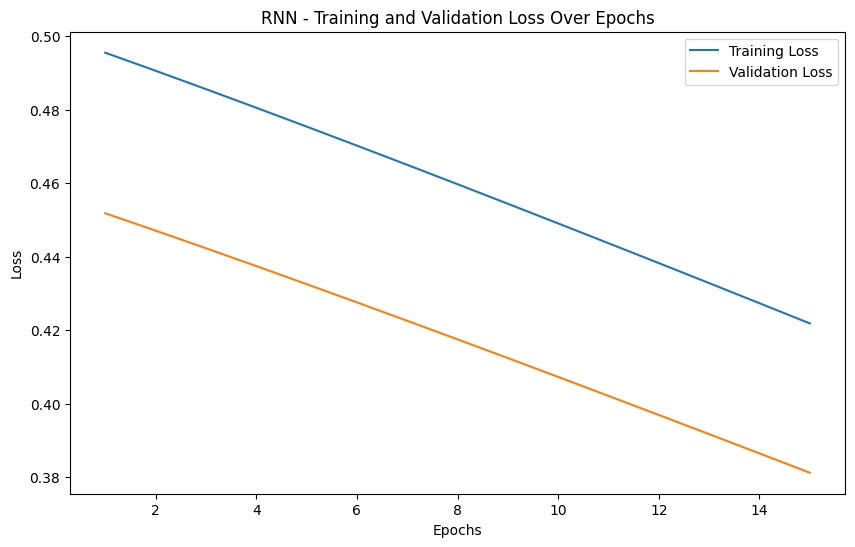

In [63]:
# Plot training and validation losses over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('RNN - Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

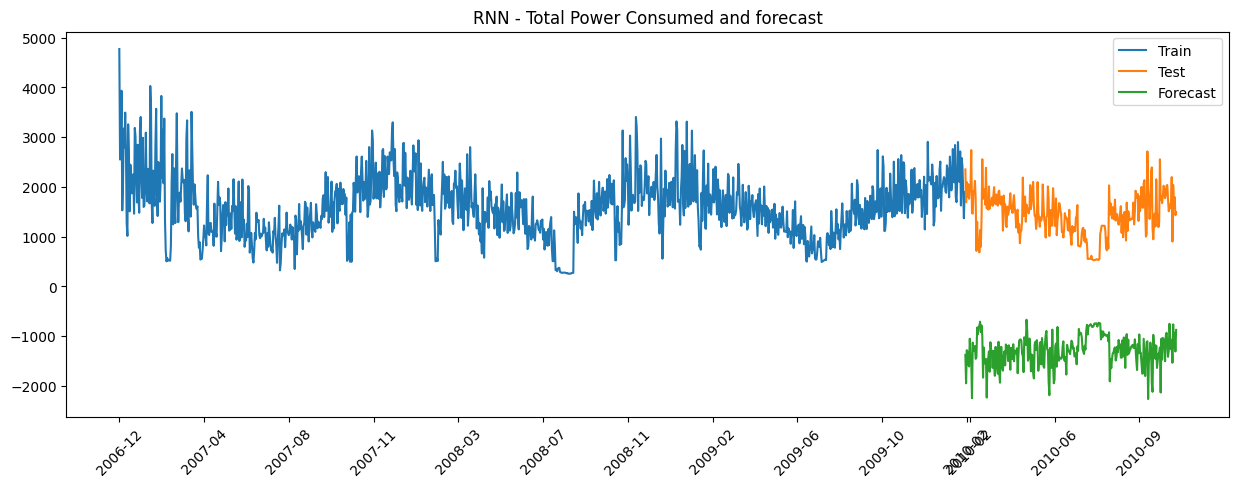

In [65]:
# Plot the actual vs predicted values

# Convert datetime index to a list of strings
date_strings_train = [str(date) for date in df.index[:timestamps_train[-1]]]
date_strings_test = [str(date) for date in df.index[timestamps_train[-1]:]]

plt.figure(figsize=(15, 5))
plt.plot(date_strings_train[:-6], y_train_original_scale, label='Train')
plt.plot(date_strings_test[:-1], y_test_original_scale, label='Test')
plt.plot(date_strings_test[:-1], y_pred_original_scale, label='Forecast')
plt.title('RNN - Total Power Consumed and forecast')

plt.legend()

# Include some dates along the x-axis with month and year
n = max(len(date_strings_train) // 10, 1)
xticks_positions = list(range(0, len(date_strings_train), n)) + list(range(len(date_strings_train), len(date_strings_train) + len(date_strings_test), n))
xticks_labels = [date_strings_train[i] for i in range(0, len(date_strings_train), n)] + [date_strings_test[i] for i in range(0, len(date_strings_test), n)]

# Format dates
xticks_labels = [pd.to_datetime(label).strftime('%Y-%m') for label in xticks_labels]

plt.xticks(xticks_positions, xticks_labels, rotation=45)

plt.show()

## LSTM Forecast

Long Short-Term Memory networks, or LSTMs, are a special kind of RNN capable of learning long-term dependencies due to their internal memory cells that regulate the flow of information. They are particularly useful for time series forecasting because they can remember information for prolonged periods, making them more effective than traditional RNNs at capturing patterns in data with long-range temporal correlations. Let's now implement an LSTM to compare it to the other methods we'ved used before.

In [66]:
# Define a function to create the LSTM model
from tensorflow.keras.layers import LSTM

def create_model(optimizer='adam'):
    model = Sequential()
    model.add(LSTM(100, input_shape=(7, 7))) # with 100 neurons
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mse')
    return model

# Wrap the model using the KerasRegressor
model = KerasRegressor(build_fn=create_model, verbose=1)

# Define the grid search parameters
param_grid = {
    'batch_size': [16, 32, 64],
    'epochs': [15, 20, 25, 30],
    'optimizer': ['adam', 'Adadelta']
}

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

# Fit the grid search to the data
grid_result = grid.fit(X_train, y_train)

# Summarize results
print('Best: {} using {}'.format(grid_result.best_score_, grid_result.best_params_))
print('All results:')

# Save best parameters in a file
best_params = grid_result.best_params_
with open('best_params.json', 'w') as file:
    json.dump(best_params, file)

#print results
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('{} ({}) with: {}'.format(mean, stdev, param))

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/30
72/72 [==============================] - 3s 6ms/step - loss: 0.0140
Epoch 2/30
72/72 [==============================] - 0s 6ms/step - loss: 0.0109
Epoch 3/30
72/72 [==============================] - 0s 6ms/step - loss: 0.0105
Epoch 4/30
72/72 [==============================] - 0s 6ms/step - loss: 0.0104
Epoch 5/30
72/72 [==============================] - 0s 6ms/step - loss: 0.0103
Epoch 6/30
72/72 [==============================] - 0s 6ms/step - loss: 0.0104
Epoch 7/30
72/72 [==============================] - 0s 5ms/step - loss: 0.0105
Epoch 8/30
72/72 [==============================] - 0s 6ms/step - loss: 0.0103
Epoch 9/30
72/72 [==============================] - 0s 6ms/step - loss: 0.0100
Epoch 10/30
72/72 [==============================] - 0s 6ms/step - loss: 0.0100
Epoch 11/30
72/72 [==============================] - 0s 6ms/step - loss: 0.0098
Epoch 12/30
72/72 [==============================] - 0s 6ms/step - loss: 0.0101
Epoch 13/30
72/72 [==============================

In [67]:
# Load and print the best parameters to verify the keys
with open('best_params.json', 'r') as f:
    best_params = json.load(f)
print(best_params)

{'batch_size': 16, 'epochs': 30, 'optimizer': 'adam'}


In [76]:
# Now let's forecast using the best parameters

# Load the best parameters from the file
with open('best_params.json', 'r') as file:
    best_params = json.load(file)

# Define the LSTM model using the loaded best parameters
model = Sequential()
model.add(LSTM(units=100, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer=best_params['optimizer'], loss='mse')

# Fit the model
history = model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=1, validation_data=(X_test, y_test))

# Access training and validation losses from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Forecast
y_pred = model.predict(X_test)

# Inverse transform the scaled predictions and target values
new_array=np.array(y_pred).reshape(-1,1)
prediction_copies_array = np.repeat(new_array,7, axis=-1)
y_pred_original_scale = scaler.inverse_transform(np.reshape(prediction_copies_array,(len(y_pred),7)))[:,0]

original_copies_array = np.repeat(y_test,7, axis=-1)
y_test_original_scale=scaler.inverse_transform(np.reshape(original_copies_array,(len(y_test),7)))[:,0]

original_train_copies_array = np.repeat(y_train,7, axis=-1)
y_train_original_scale=scaler.inverse_transform(np.reshape(original_train_copies_array,(len(y_train),7)))[:,0]

#Save the model to use to forecast
model.save('my_model.h5')

# Calculate RMSE and MAE
rmse_LSTM = sqrt(mean_squared_error(y_test_original_scale, y_pred_original_scale))
mae_LSTM = mean_absolute_error(y_test_original_scale, y_pred_original_scale)

print('Test MAE: %.3f' % mae_LSTM)
print('Test RMSE: %.3f' % rmse_LSTM)

Epoch 1/30
72/72 [==============================] - 4s 28ms/step - loss: 0.0189 - val_loss: 0.0061
Epoch 2/30
72/72 [==============================] - 1s 10ms/step - loss: 0.0108 - val_loss: 0.0055
Epoch 3/30
72/72 [==============================] - 1s 7ms/step - loss: 0.0105 - val_loss: 0.0056
Epoch 4/30
72/72 [==============================] - 1s 7ms/step - loss: 0.0105 - val_loss: 0.0050
Epoch 5/30
72/72 [==============================] - 0s 7ms/step - loss: 0.0103 - val_loss: 0.0052
Epoch 6/30
72/72 [==============================] - 1s 7ms/step - loss: 0.0100 - val_loss: 0.0049
Epoch 7/30
72/72 [==============================] - 0s 7ms/step - loss: 0.0098 - val_loss: 0.0049
Epoch 8/30
72/72 [==============================] - 0s 7ms/step - loss: 0.0097 - val_loss: 0.0050
Epoch 9/30
72/72 [==============================] - 0s 7ms/step - loss: 0.0094 - val_loss: 0.0051
Epoch 10/30
72/72 [==============================] - 0s 7ms/step - loss: 0.0093 - val_loss: 0.0049
Epoch 11/30
72/72

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


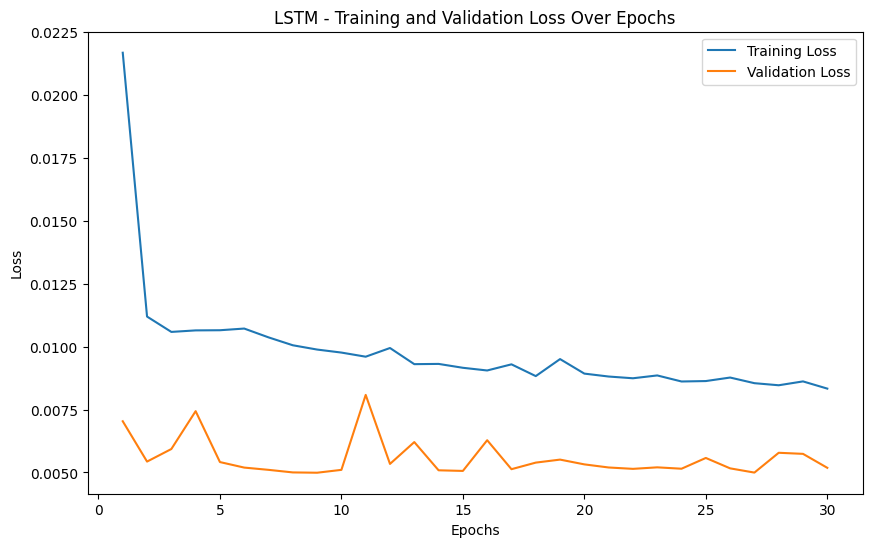

In [69]:
# Plot training and validation losses over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('LSTM - Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

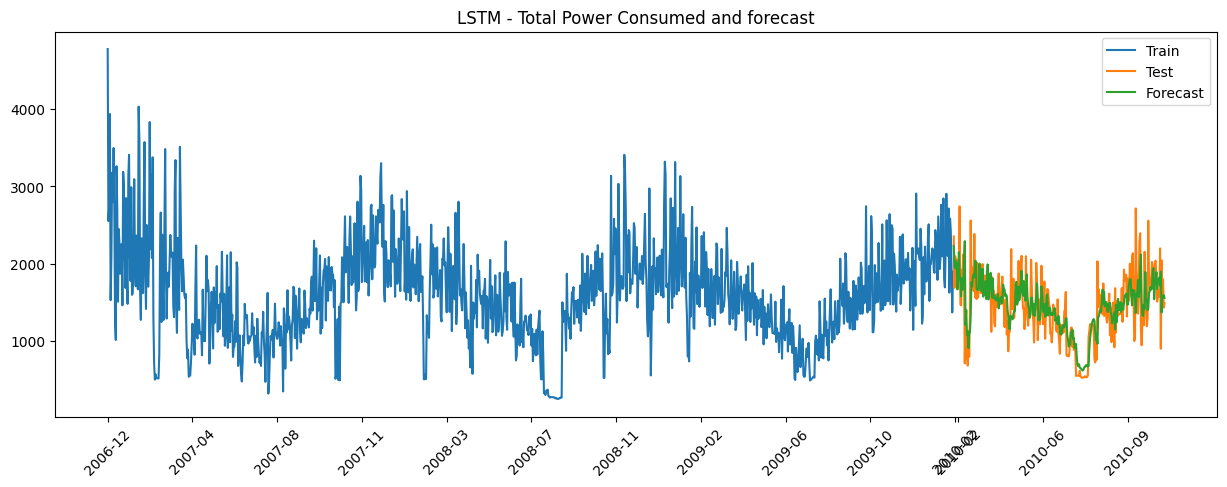

In [81]:
# Plot the actual vs predicted values

# Convert datetime index to a list of strings
date_strings_train = [str(date) for date in df.index[:timestamps_train[-1]]]
date_strings_test = [str(date) for date in df.index[timestamps_train[-1]:]]

plt.figure(figsize=(15, 5))
plt.plot(date_strings_train[:-6], y_train_original_scale, label='Train')
plt.plot(date_strings_test[:-1], y_test_original_scale, label='Test')
plt.plot(date_strings_test[:-1], y_pred_original_scale, label='Forecast')
plt.title('LSTM - Total Power Consumed and forecast')

plt.legend()

# Include some dates along the x-axis with month and year
n = max(len(date_strings_train) // 10, 1)
xticks_positions = list(range(0, len(date_strings_train), n)) + list(range(len(date_strings_train), len(date_strings_train) + len(date_strings_test), n))
xticks_labels = [date_strings_train[i] for i in range(0, len(date_strings_train), n)] + [date_strings_test[i] for i in range(0, len(date_strings_test), n)]

# Format dates
xticks_labels = [pd.to_datetime(label).strftime('%Y-%m') for label in xticks_labels]

plt.xticks(xticks_positions, xticks_labels, rotation=45)

plt.show()

## 4. Result Comparisson

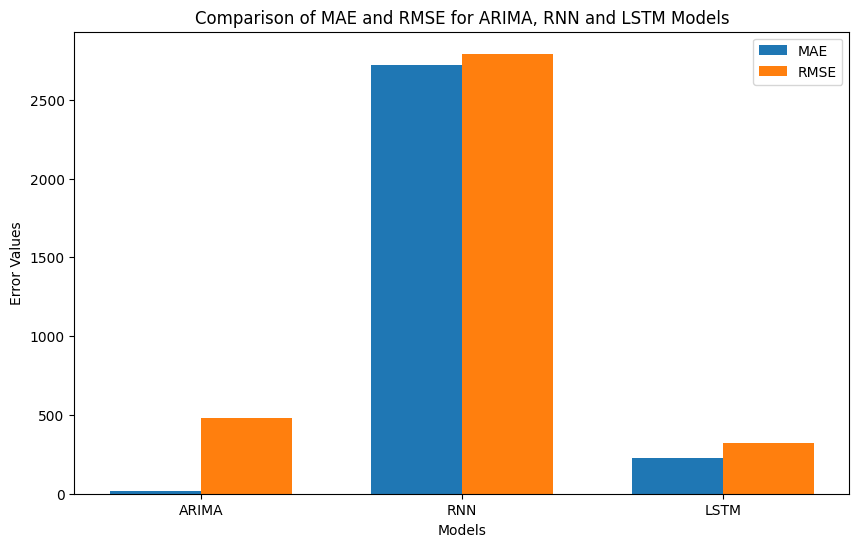

In [80]:
import matplotlib.pyplot as plt
import numpy as np

# Organize data
models = ['ARIMA', 'RNN', 'LSTM']
mae_values = [mae_Arima, mae_rnn, mae_LSTM]
rmse_values = [rmse_Arima, rmse_rnn, rmse_LSTM]


bar_width = 0.35 # Bar width

# Set positions for the bars
index = np.arange(len(models))

# Create bar plots
plt.bar(index, mae_values, bar_width, label='MAE')
plt.bar(index + bar_width, rmse_values, bar_width, label='RMSE')

# Customize the plot
plt.xlabel('Models')
plt.ylabel('Error Values')
plt.title('Comparison of MAE and RMSE for ARIMA, RNN and LSTM Models')
plt.xticks(index + bar_width / 2, models)
plt.legend()


plt.show()


## 5. References

We worked on the problem set as independently as possible and got assistance from ChatGPT and Julius.ai when needed. We utilized the following resources to get a deeper understanding of the challenges posed by the problem set:
- Dive into Deep Learning - https://d2l.ai/
- Peixeiro, Marco. Time series forecasting in python,  ISBN 9781617299889, 2022. Available at https://www.manning.com/books/time-series-forecasting-in-python-book
- Multivariate Time Series Forecasting with LSTMs in Keras - https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
- Exploring the LSTM Neural Network Model for Time Series - https://towardsdatascience.com/exploring-the-lstm-neural-network-model-for-time-series-8b7685aa8cf
- Multivariate Multi-step Time Series Forecasting using Stacked LSTM sequence to sequence Autoencoder in Tensorflow 2.0 / Keras - https://www.analyticsvidhya.com/blog/2020/10/multivariate-multi-step-time-series-forecasting-using-stacked-lstm-sequence-to-sequence-autoencoder-in-tensorflow-2-0-keras/#wait_approval
- MULTIVARIATE TIME SERIES FORECASTING USING LSTM - https://medium.com/@786sksujanislam786/multivariate-time-series-forecasting-using-lstm-4f8a9d32a509
- Multiple Series? Forecast Them together with any Sklearn Model - https://towardsdatascience.com/multiple-series-forecast-them-together-with-any-sklearn-model-96319d46269
- Guide to Time Series Analysis with Python — 1: Analysis Techniques and Baseline Model - https://buse-koseoglu13.medium.com/guide-to-time-series-analysis-with-python-1-analysis-techniques-and-baseline-model-59e12fdd2eba
-